# Get predictions

In [9]:
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad

# Path to Neural Fingerprint scripts
import sys
sys.path
sys.path.append('../../../scripts/baselines/neuralfingerprints/utils')
sys.path.append('../../../scripts/baselines/neuralfingerprints')

from build_vanilla_net import build_morgan_deep_net
from build_convnet import build_conv_deep_net
from util import normalize_array, build_batched_grad
from optimizers import adam
from util import rmse
from sklearn.metrics import r2_score

from pathlib2 import Path
import time
import os
import json
import pickle
from argparse import ArgumentParser

from training_funcs import load_data

In [10]:
NUM_EXP = 200

In [11]:
# path to datasets
DATASET_PATH = "../../../data/3_final_data/split_data"

# path to logs directory
EXPERIMENTS_DATA = "../../../data/raw/baselines/neuralfingerprint"

# logs path
LOG_PATH=os.path.join(EXPERIMENTS_DATA, "logs")

MODEL_PATH=os.path.join(EXPERIMENTS_DATA, "models")

In [12]:
path = os.path.join(LOG_PATH,'exp_'+str(NUM_EXP))
LOG_PATH = path

path = os.path.join(MODEL_PATH,'exp_'+str(NUM_EXP))
MODEL_PATH = path

In [13]:
class Args(object):
    def __init__(self, adict):
        self.__dict__.update(adict)

In [14]:
with open(os.path.join(LOG_PATH,str(NUM_EXP)+'_parameters.json'),'r') as f:
    args = Args(json.load(f))

In [15]:
# set data parameters
task_params = {'target_name' : 'logP',
           'data_file'   : args.data_file}

# load data
data = load_data(dataset_path=DATASET_PATH, prefix_name = task_params['data_file'], VALUE_COLUMN = task_params['target_name'])

train_inputs, train_targets = data['train']
val_inputs,   val_targets   = data['validation']
test_inputs,  test_targets  = data['test']

# set parameters of training    
params = {'fp_length': args.fp_length,
        'fp_depth': args.fp_depth,
        'init_scale': np.exp(args.init_scale),
        'learn_rate': np.exp(args.learn_rate),
        'l2_penalty': np.exp(args.l2_penalty),
        'l1_penalty': 0,
          'h1_size':args.h1_size,
        'conv_width':args.conv_width,
         'batch_size':100}
params['num_iters'] = args.num_epochs*len(train_inputs)/params['batch_size']

In [16]:
vanilla_net_params = dict(
    layer_sizes = [params['fp_length'], params['h1_size']],  # One hidden layer.
    normalize=True, L2_reg = params['l2_penalty'], L1_reg = params['l1_penalty'], nll_func = rmse)

In [17]:
conv_layer_sizes = [params['conv_width']] * params['fp_depth']
conv_arch_params = {'num_hidden_features' : conv_layer_sizes,
                    'fp_length' : params['fp_length'], 'normalize' : 1}
loss_fun, pred_fun, conv_parser = \
    build_conv_deep_net(conv_arch_params, vanilla_net_params, params['l2_penalty'])
num_weights = len(conv_parser)

In [18]:
best_model_name = filter(lambda x: x.startswith('model_best'), os.listdir(MODEL_PATH))

In [19]:
with open(os.path.join(MODEL_PATH, best_model_name[0])) as f:
    best_weights = pickle.load(f)

# Create files with predictions

In [20]:
DATASET_OUTPUT_PATH = '../../../data/4_best_baselines_predictions/neuralfingerprint'

SMILES_COLUMN = 'smiles'
VALUE_COLUMN = 'logP'
PREDS_COLUMN = 'logP_pred'

In [21]:
train_norm_targets, undo_norm = normalize_array(train_targets)

In [22]:
train_preds = undo_norm(pred_fun(best_weights, train_inputs))

In [23]:
val_preds = undo_norm(pred_fun(best_weights, val_inputs))
test_preds = undo_norm(pred_fun(best_weights, test_inputs))

In [24]:
def create_predictions_file(smiles, targets, preds, dataset_output_path, filename_prefix):
    import pandas as pd
    data = pd.DataFrame(columns=[SMILES_COLUMN, VALUE_COLUMN, PREDS_COLUMN])
    data[SMILES_COLUMN] = smiles
    data[VALUE_COLUMN] = targets
    data[PREDS_COLUMN] = preds
    data.to_csv(os.path.join(dataset_output_path, filename_prefix+'.csv'), index = False)
    return data

In [25]:
args.data_file

u'logp_wo_averaging'

In [56]:
splits = ['train', 'validation','test']

data_splits = [[train_inputs, train_targets, train_preds],\
               [val_inputs, val_targets, val_preds],\
               [test_inputs, test_targets, test_preds]]

predictions = {}

for i, split in enumerate(splits):
    predictions[split] = create_predictions_file(smiles = data_splits[i][0], \
                                                 targets = data_splits[i][1], \
                                                 preds = data_splits[i][2], \
                            dataset_output_path = DATASET_OUTPUT_PATH, filename_prefix = args.data_file+'_'+split+'_preds')

# Get worst/best molecules

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

In [65]:
ERROR_COLUMN = 'Absolute Error'
NUM_ATOMS_COLUMN = 'Number of atoms'
SMILES_COLUMN = 'smiles'
VALUE_COLUMN = 'logP'
PREDS_COLUMN = 'logP_pred'

DATASET_INPUT_PATH = '../../../data/4_best_baselines_predictions/neuralfingerprint'

DATASET_OUTPUT_PATH = '../../../data/raw/baselines/neuralfingerprint'

In [66]:
test_predictions = pd.read_csv(os.path.join(DATASET_INPUT_PATH, 'logp_wo_averaging_test_preds.csv'))

In [67]:
def calc_number_of_atoms(smiles):
    m = Chem.MolFromSmiles(smiles)
    return m.GetNumAtoms()

In [68]:
test_predictions[NUM_ATOMS_COLUMN] = test_predictions[SMILES_COLUMN].apply(calc_number_of_atoms)

In [69]:
test_predictions[ERROR_COLUMN] = np.abs(test_predictions[VALUE_COLUMN]-test_predictions[PREDS_COLUMN])

In [70]:
test_predictions

,smiles,logP,logP_pred,Number of atoms,Absolute Error
0,CC(=O)NC(Cc1ccccc1)C(=O)NC(Cc1ccccc1)C(=O)N(C)...,2.63,1.856125,38,0.773875
1,CC(C)n1c(/C=C/[C@@H](O)C[C@@H](O)CC(=O)O)c(-c2...,4.17,4.261815,30,0.091815
2,CCS(=O)c1sc(C(C)=O)c(N)c1C#N,1.82,0.933764,15,0.886236
3,O=P(Oc1ccccc1)(Oc1ccccc1)Oc1ccccc1,4.59,4.428985,23,0.161015
4,OC1(c2cc(Cl)ccc2Cl)CCCCC1n1cncn1,3.24,2.948154,20,0.291846
...,...,...,...,...,...
2062,CSc1nc2c(=N)[nH]cnc2n1C1OC2CO[PH](=O)(=O)OC2C1O,-2.03,-2.023968,24,0.006032
2063,Cn1c(=O)c2[nH]cnc2n(C)c1=O,-0.02,-0.892797,13,0.872797
2064,N=c1[nH]c(=O)c2ncn(COC(CO)CO)c2[nH]1,-1.66,-1.942639,18,0.282639
2065,O=C(Oc1ccccc1)c1ccccc1,3.59,3.489935,15,0.100065


In [71]:
test_predictions = test_predictions.sort_values(by=ERROR_COLUMN)

In [72]:
test_predictions

,smiles,logP,logP_pred,Number of atoms,Absolute Error
1221,Nc1cccc2ncccc12,1.16,1.159872,11,0.000128
1790,O=C1NC(=O)C(=Cc2ccc([N+](=O)[O-])o2)S1,0.63,0.629751,16,0.000249
537,N#Cc1ccccn1,0.45,0.450714,8,0.000714
253,Brc1cccnc1,1.60,1.598423,7,0.001577
1587,CCOCN(C(=O)CCl)c1c(C)cccc1CC,3.03,3.028362,18,0.001638
...,...,...,...,...,...
1824,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1,-0.21,3.180122,22,3.390122
1220,O=c1ccc(=[N+]([O-])O)c(=O)c1=[N+]([O-])O,2.10,-1.384193,14,3.484193
1730,O=C(O[K])C1C2CCC(O2)C1C(=O)O[K],0.32,-3.695250,15,4.015250
1727,O=S(=O)(O)c1cc(N=c2[nH]c(N3CCOCC3)nc(=Nc3ccccc...,1.48,6.048853,62,4.568853


In [73]:
test_predictions.to_csv(os.path.join(DATASET_OUTPUT_PATH,'predictions_table.csv'), index = False)

## Draw best molecules

In [2]:
import os
import numpy as np

In [3]:
SMILES_COLUMN = 'smiles'
VALUE_COLUMN = 'logP'
PREDS_COLUMN = 'logP_pred'

In [4]:
DATA_PATH = '../../../data/raw/baselines/neuralfingerprint'

In [5]:
test_predictions = pd.read_csv(os.path.join(DATA_PATH,'predictions_table.csv'))

In [ ]:
sorted_smiles = test_predictions[SMILES_COLUMN].values

In [ ]:
NUMBER_OF_BEST = 100
NUMBER_OF_WORST = 100

In [133]:
best_pred_smiles = sorted_smiles[:NUMBER_OF_BEST]
worst_pred_smiles = sorted_smiles[-NUMBER_OF_WORST:]

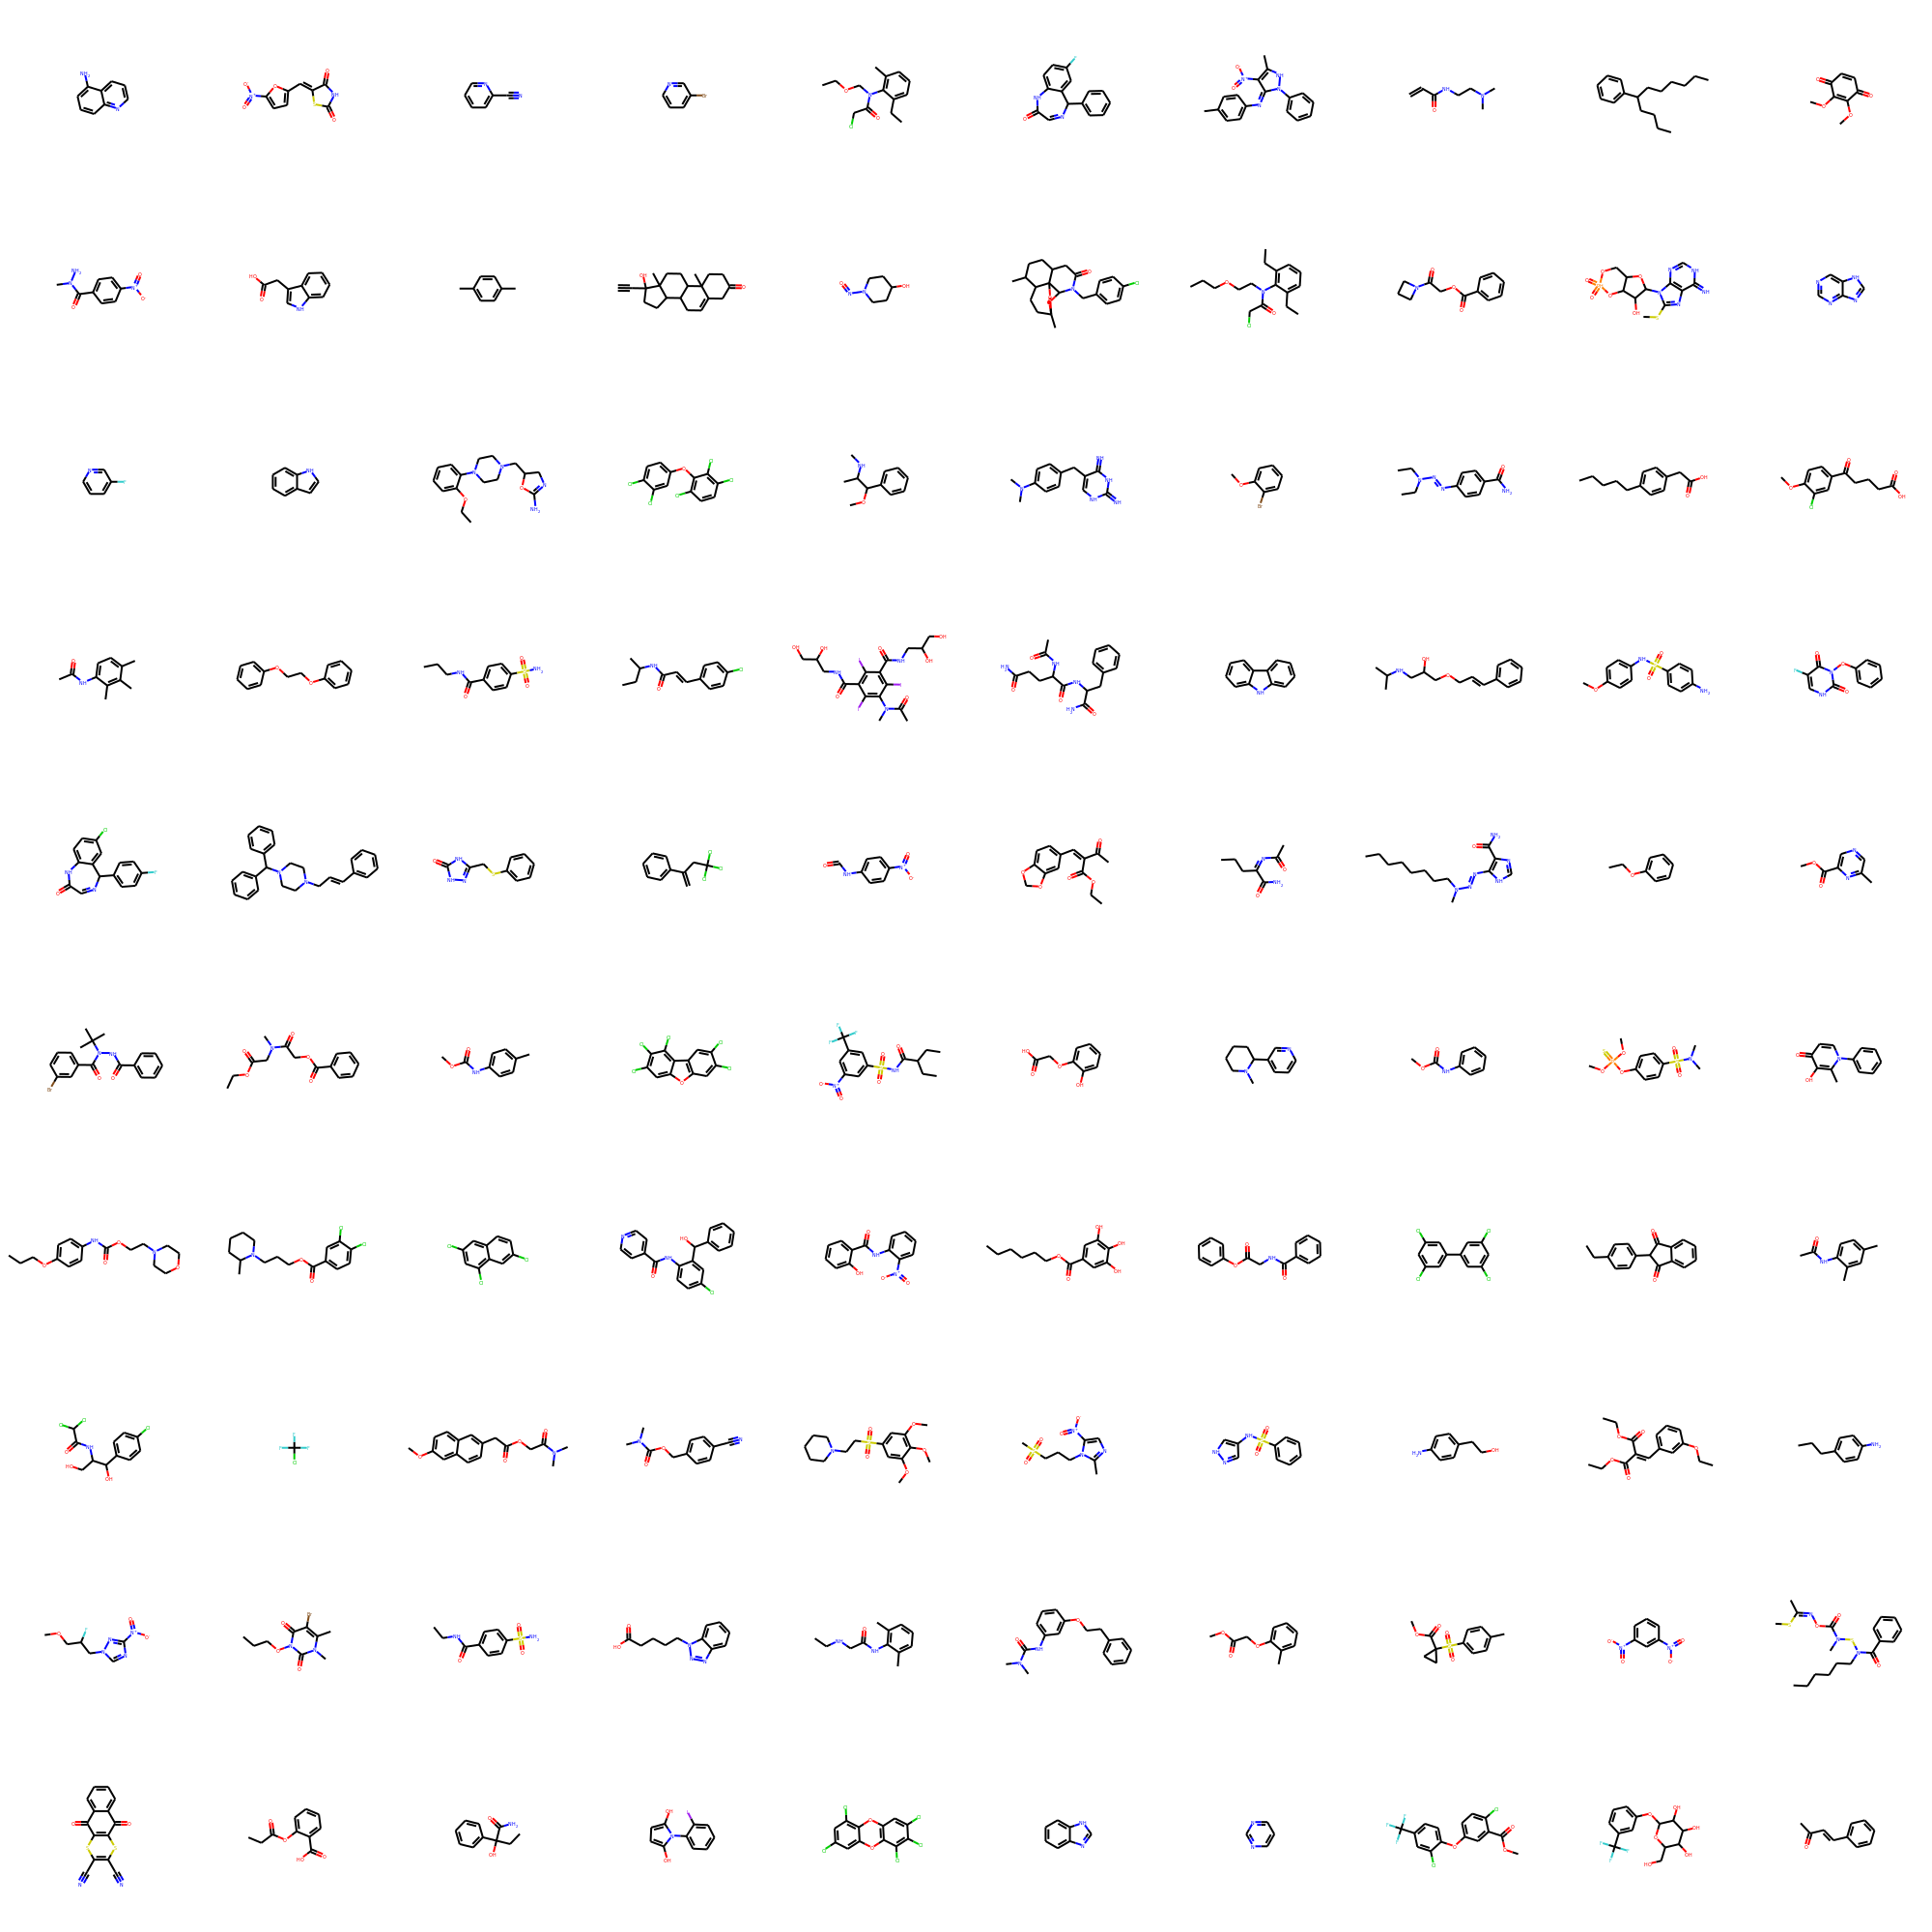

In [140]:
ms = [Chem.MolFromSmiles(smiles) for smiles in best_pred_smiles]
img=Draw.MolsToGridImage(ms,molsPerRow=10,subImgSize=(200,200))#,legends=[smiles for smiles in best_pred_smiles])    
img.save('../../../../NF_best_preds_lq.png')
img

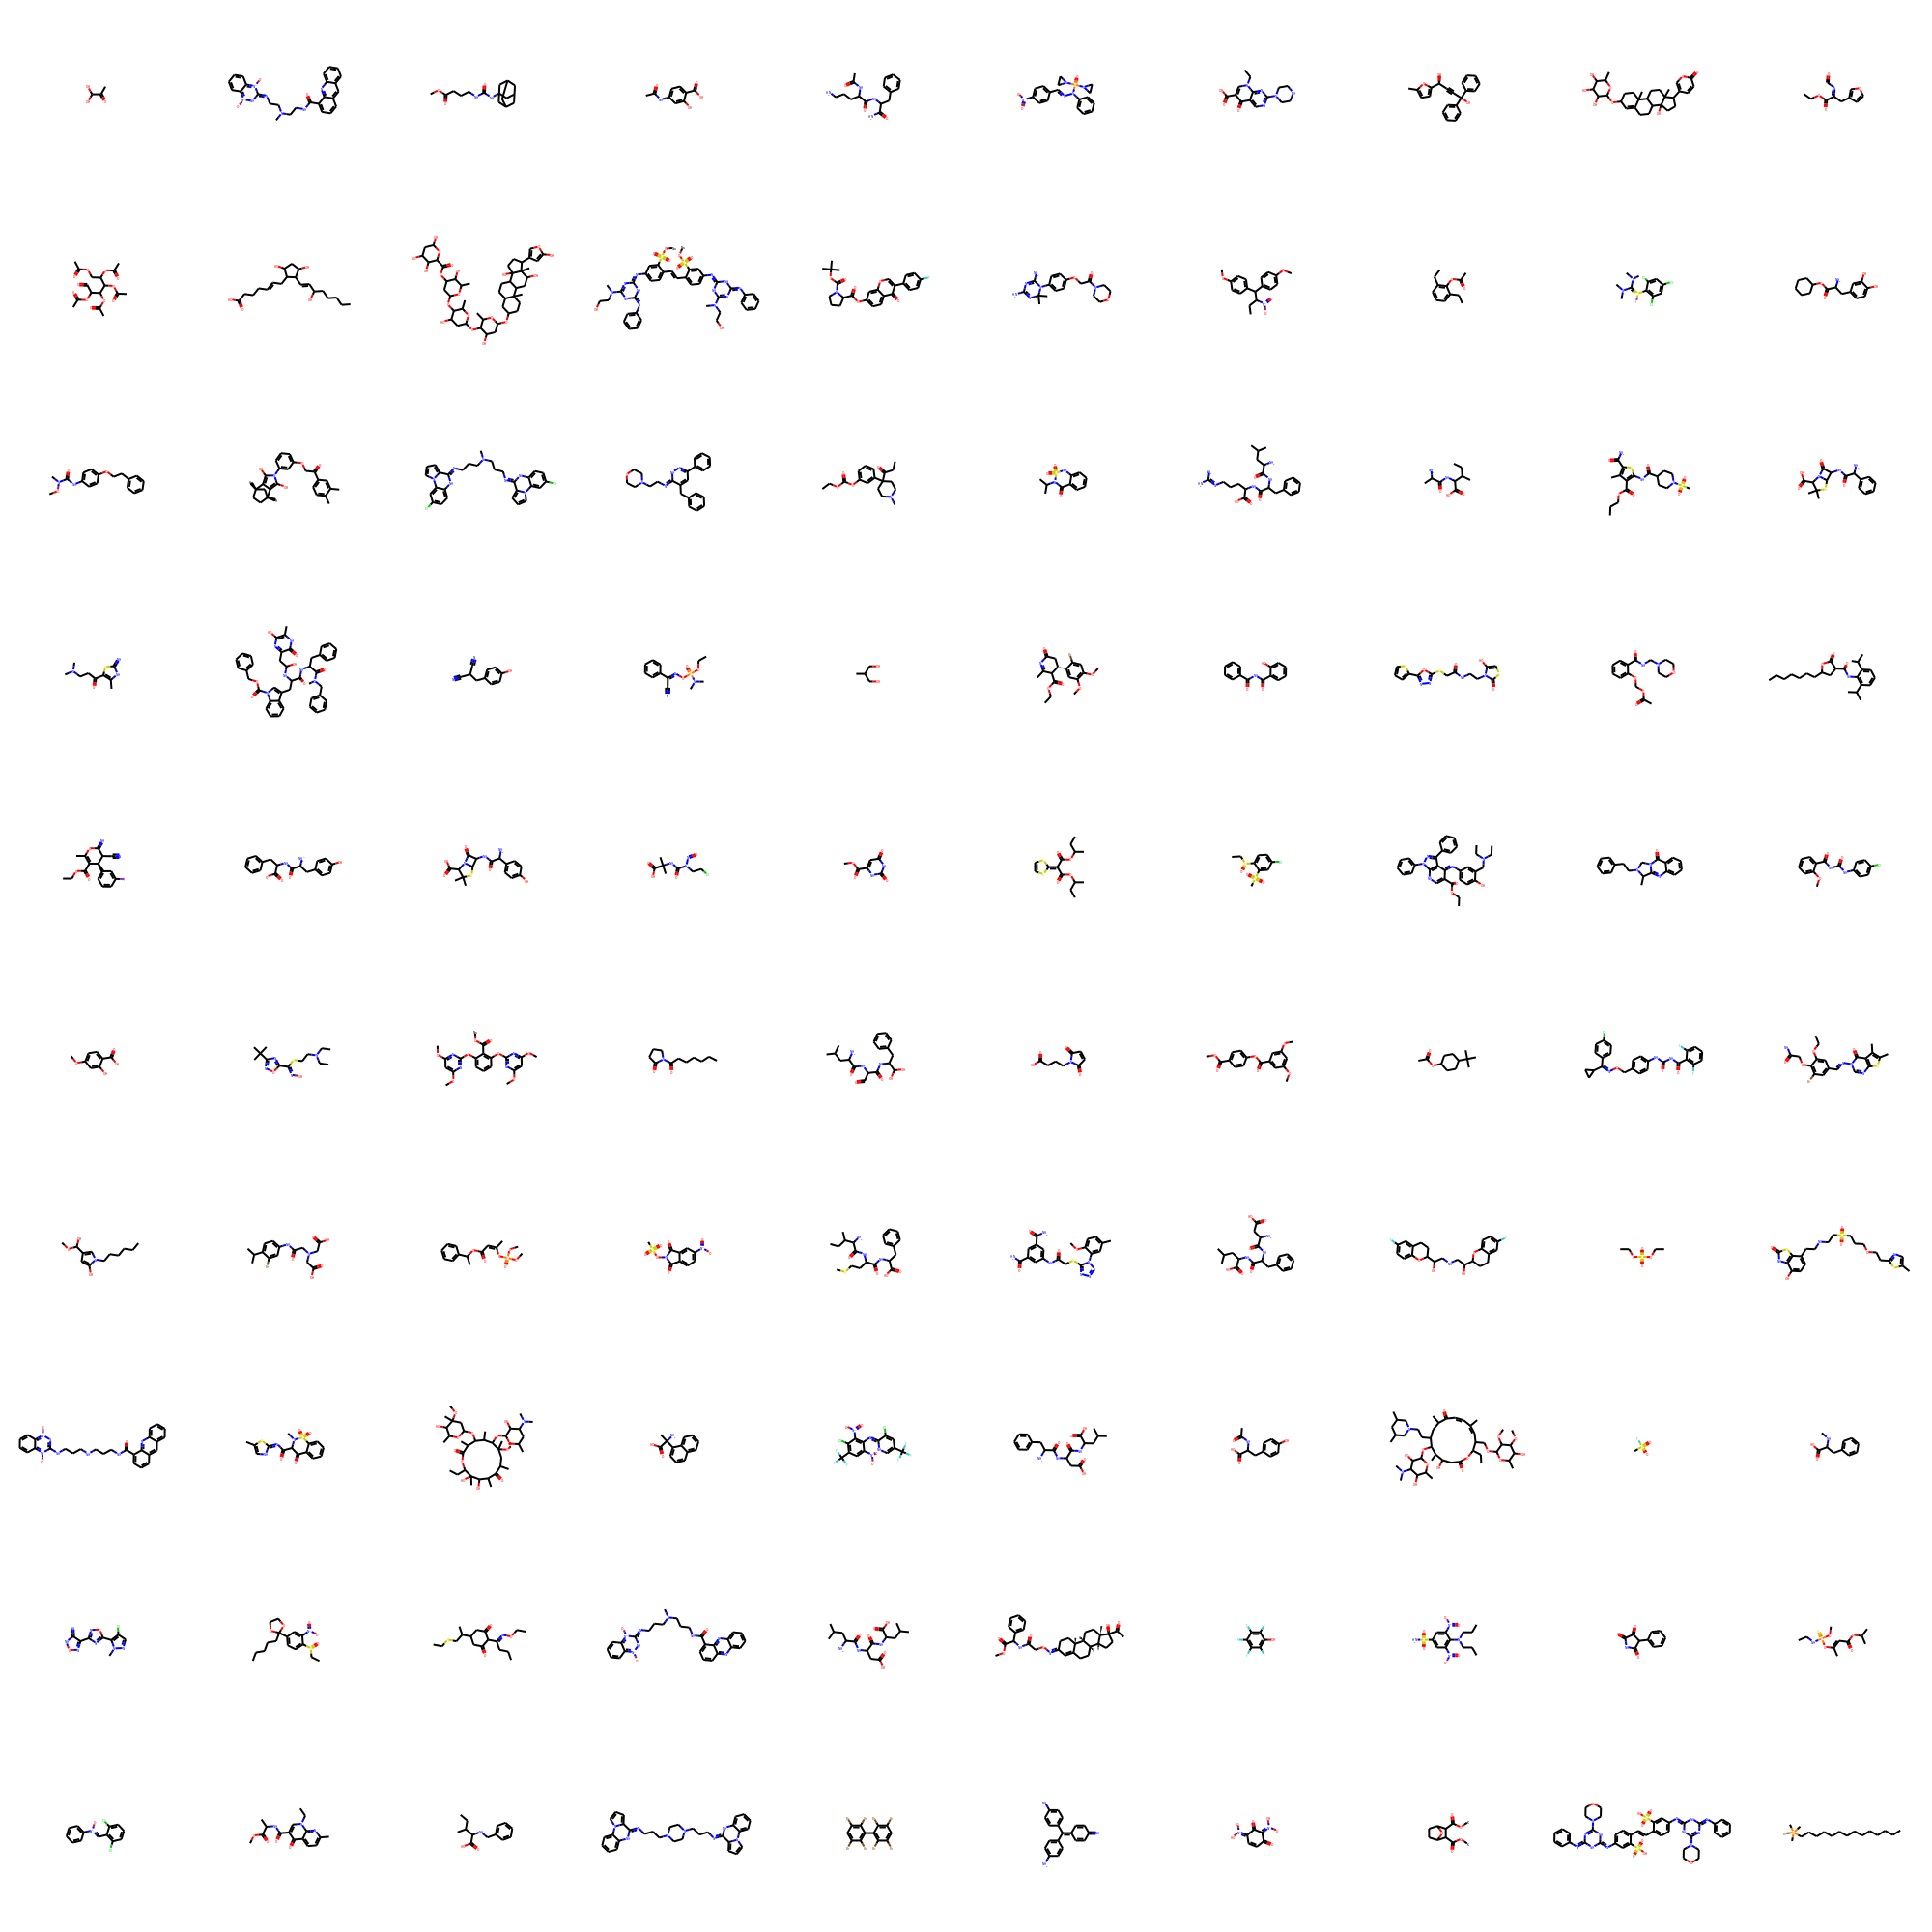

In [139]:
ms = [Chem.MolFromSmiles(smiles) for smiles in worst_pred_smiles]
img=Draw.MolsToGridImage(ms,molsPerRow=10,subImgSize=(200,200))#,legends=[smiles for smiles in worst_pred_smiles])    
img.save('../../../../NF_worst_preds_lq.png')
img

## Get statistics

In [6]:
from scipy import stats
import seaborn as sns

In [7]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values.smiles]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [len(values) == len(values[values % 2 == 0]) for values in values_list]
    
    return values

In [8]:
compare_data_with_stats = create_statistics(test_predictions)

In [9]:
compare_data_with_stats.head()

,smiles,logP,logP_pred,Number of atoms,Absolute Error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,Nc1cccc2ncccc12,1.16,1.159872,11,0.000128,11,2,0,0.000000,1,50.0,12,11,91.666667,False
1,O=C1NC(=O)C(=Cc2ccc([N+](=O)[O-])o2)S1,0.63,0.629751,16,0.000249,16,2,1,6.250000,0,0.0,17,5,29.411765,False
2,N#Cc1ccccn1,0.45,0.450714,8,0.000714,8,1,0,0.000000,0,0.0,8,6,75.000000,False
3,Brc1cccnc1,1.60,1.598423,7,0.001577,7,1,1,14.285714,0,0.0,7,6,85.714286,False
4,CCOCN(C(=O)CCl)c1c(C)cccc1CC,3.03,3.028362,18,0.001638,18,1,1,5.555556,1,100.0,18,6,33.333333,False


In [94]:
compare_data_with_stats

,smiles,logP,logP_pred,Number of atoms,Absolute Error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,Nc1cccc2ncccc12,1.16,1.159872,11,0.000128,11,2,0,0.000000,1,50.000000,12,11,91.666667,False
1,O=C1NC(=O)C(=Cc2ccc([N+](=O)[O-])o2)S1,0.63,0.629751,16,0.000249,16,2,1,6.250000,0,0.000000,17,5,29.411765,False
2,N#Cc1ccccn1,0.45,0.450714,8,0.000714,8,1,0,0.000000,0,0.000000,8,6,75.000000,False
3,Brc1cccnc1,1.60,1.598423,7,0.001577,7,1,1,14.285714,0,0.000000,7,6,85.714286,False
4,CCOCN(C(=O)CCl)c1c(C)cccc1CC,3.03,3.028362,18,0.001638,18,1,1,5.555556,1,100.000000,18,6,33.333333,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2062,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1,-0.21,3.180122,22,3.390122,22,3,0,0.000000,2,66.666667,24,12,50.000000,False
2063,O=c1ccc(=[N+]([O-])O)c(=O)c1=[N+]([O-])O,2.10,-1.384193,14,3.484193,14,1,0,0.000000,1,100.000000,14,6,42.857143,False
2064,O=C(O[K])C1C2CCC(O2)C1C(=O)O[K],0.32,-3.695250,15,4.015250,15,2,2,13.333333,0,0.000000,16,0,0.000000,False
2065,O=S(=O)(O)c1cc(N=c2[nH]c(N3CCOCC3)nc(=Nc3ccccc...,1.48,6.048853,62,4.568853,62,8,2,3.225806,4,50.000000,69,36,52.173913,True


### Split data in 3 parts (best, middle, worst)

In [11]:
NUMBER_OF_BEST = 200
NUMBER_OF_WORST = 200

In [14]:
best, middle, worst = np.array_split(compare_data_with_stats, 3)
middle = middle.reset_index()
worst = worst.reset_index()

NameError: name 'compare_data_with_stats' is not defined

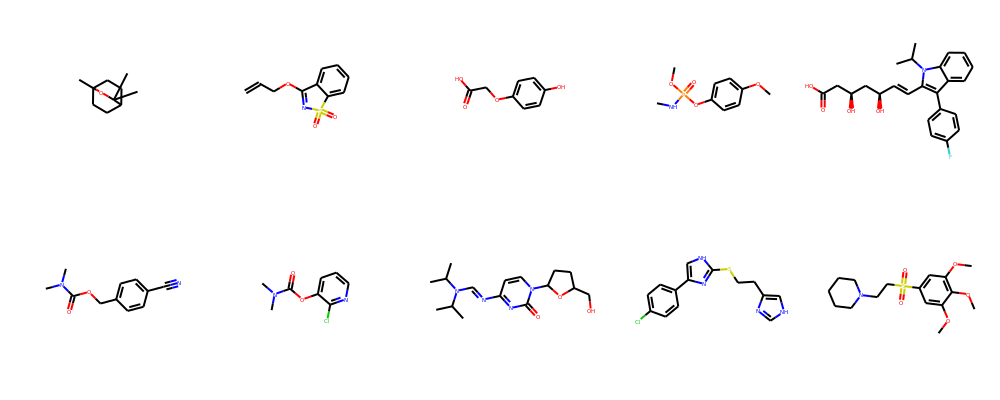

In [96]:
# Look through random 10 molecules from "best part"
ms = [Chem.MolFromSmiles(smiles) for smiles in best.sample(10).smiles]
img=Draw.MolsToGridImage(ms,molsPerRow=5,subImgSize=(200,200))#,legends=[smiles for smiles in worst_pred_smiles])    
img


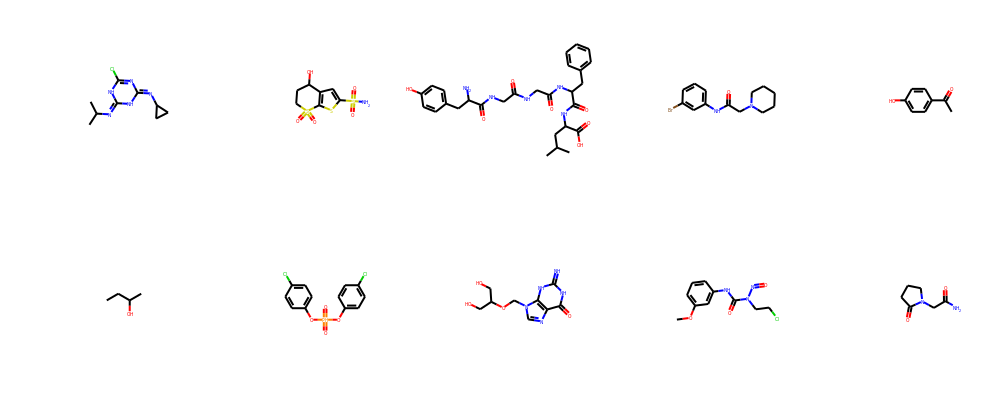

In [97]:
# Look through random 10 molecules from "middle part"
ms = [Chem.MolFromSmiles(smiles) for smiles in middle.sample(10).smiles]
img=Draw.MolsToGridImage(ms,molsPerRow=5,subImgSize=(200,200))#,legends=[smiles for smiles in worst_pred_smiles])    
img

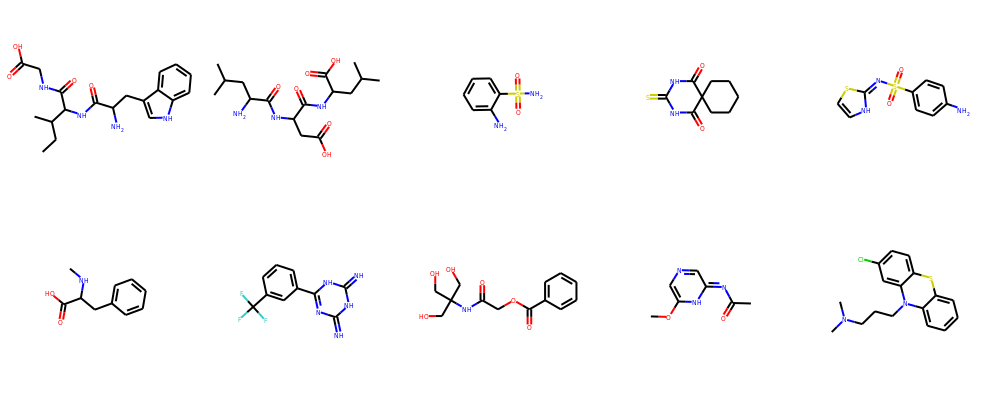

In [98]:
# Look through random 10 molecules from "worst part"
ms = [Chem.MolFromSmiles(smiles) for smiles in worst.sample(10).smiles]
img=Draw.MolsToGridImage(ms,molsPerRow=5,subImgSize=(200,200))#,legends=[smiles for smiles in worst_pred_smiles])    
img

In [10]:
best_n_vals = compare_data_with_stats.iloc[:NUMBER_OF_BEST]

NameError: name 'NUMBER_OF_BEST' is not defined

In [ ]:
best_n_vals.head()

In [145]:
worst_n_vals = compare_data_with_stats.iloc[-NUMBER_OF_WORST:].sort_values(by=ERROR_COLUMN, ascending = False)

In [146]:
worst_n_vals.head()

,smiles,logP,logP_pred,Number of atoms,Absolute Error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
2066,CCCCCCCCCCCCCCP(C)(C)(C)Br,2.06,6.993669,19,4.933669,19,0,2,10.526316,0,0.000000,18,0,0.000000,False
2065,O=S(=O)(O)c1cc(N=c2[nH]c(N3CCOCC3)nc(=Nc3ccccc...,1.48,6.048853,62,4.568853,62,8,2,3.225806,4,50.000000,69,36,52.173913,True
2064,O=C(O[K])C1C2CCC(O2)C1C(=O)O[K],0.32,-3.695250,15,4.015250,15,2,2,13.333333,0,0.000000,16,0,0.000000,False
2063,O=c1ccc(=[N+]([O-])O)c(=O)c1=[N+]([O-])O,2.10,-1.384193,14,3.484193,14,1,0,0.000000,1,100.000000,14,6,42.857143,False
2062,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1,-0.21,3.180122,22,3.390122,22,3,0,0.000000,2,66.666667,24,12,50.000000,False


### Check atom_count influence

In [11]:
print(stats.kruskal(best_n_vals.atom_count, worst_n_vals.atom_count))

NameError: name 'best_n_vals' is not defined

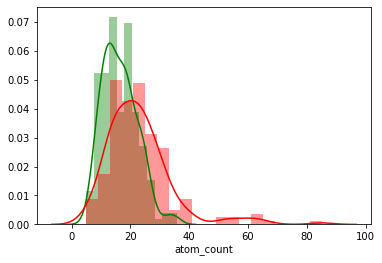

In [148]:
sns.distplot(best_n_vals.atom_count, color='g')
sns.distplot(worst_n_vals.atom_count, color='r')

### Check ring_count influence

In [149]:
print(stats.ttest_ind(best_n_vals.ring_count, worst_n_vals.ring_count))

Ttest_indResult(statistic=-3.7632351270548123, pvalue=0.00019296473537604026)


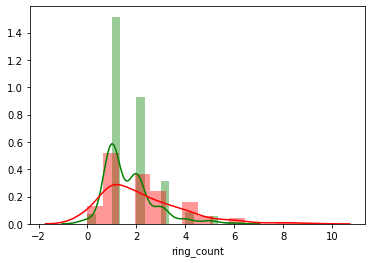

In [151]:
sns.distplot(best_n_vals.ring_count, color='g')
sns.distplot(worst_n_vals.ring_count, color='r')

### Check non_organogens_count influence

In [152]:
print(stats.ttest_ind(best_n_vals.non_organogens_count, worst_n_vals.non_organogens_count))

Ttest_indResult(statistic=0.561596114937797, pvalue=0.5747073176090087)


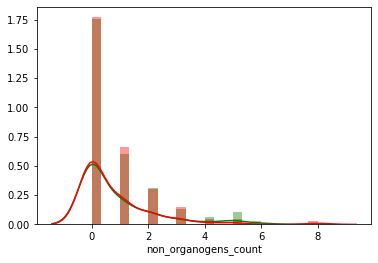

In [153]:
sns.distplot(best_n_vals.non_organogens_count, color='g')
sns.distplot(worst_n_vals.non_organogens_count, color='r')

### Check non_organogens_percent influence

In [154]:
print(stats.ttest_ind(best_n_vals.non_organogens_percent, worst_n_vals.non_organogens_percent))

Ttest_indResult(statistic=1.804356720685702, pvalue=0.07193124134043521)


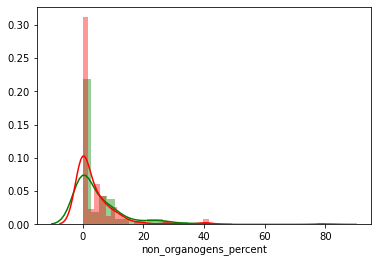

In [155]:
sns.distplot(best_n_vals.non_organogens_percent, color='g')
sns.distplot(worst_n_vals.non_organogens_percent, color='r')

### Check aromatic_count influence

In [156]:
print(stats.ttest_ind(best_n_vals.aromatic_count, worst_n_vals.aromatic_count))

Ttest_indResult(statistic=0.6669298455311892, pvalue=0.5052033995679108)


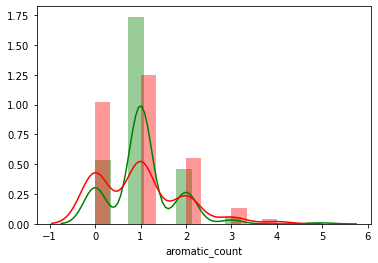

In [157]:
sns.distplot(best_n_vals.aromatic_count, color='g')
sns.distplot(worst_n_vals.aromatic_count, color='r')

### Check aromatic_rings_percent influence

In [158]:
print(stats.ttest_ind(best_n_vals.aromatic_rings_percent, worst_n_vals.aromatic_rings_percent))

Ttest_indResult(statistic=4.857256734544769, pvalue=1.714093360265696e-06)


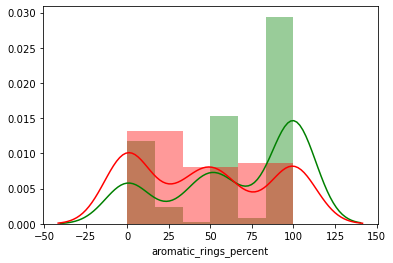

In [159]:
sns.distplot(best_n_vals.aromatic_rings_percent, color='g')
sns.distplot(worst_n_vals.aromatic_rings_percent, color='r')

### Check aromatic bond percent

In [160]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_percent, worst_n_vals.aromatic_bond_percent))

Ttest_indResult(statistic=6.400887925679889, pvalue=4.3516847323706283e-10)


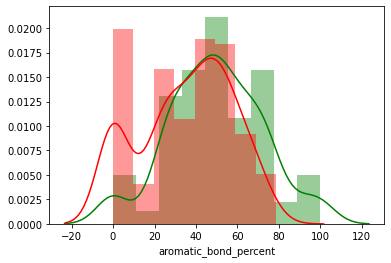

In [161]:
sns.distplot(best_n_vals.aromatic_bond_percent, color='g')
sns.distplot(worst_n_vals.aromatic_bond_percent, color='r')

### Check aromatic bond count

In [162]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_count, worst_n_vals.aromatic_bond_count))

Ttest_indResult(statistic=-1.1049641325381543, pvalue=0.26984265950427144)


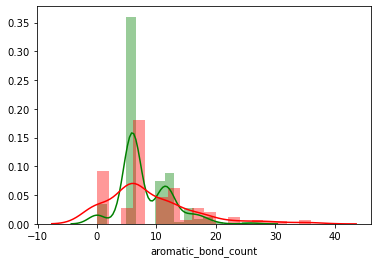

In [163]:
sns.distplot(best_n_vals.aromatic_bond_count, color='g')
sns.distplot(worst_n_vals.aromatic_bond_count, color='r')

### Symmetry analysis

In [177]:
from sklearn.metrics import mean_squared_error

In [166]:
data = compare_data_with_stats

In [168]:
mols = [Chem.MolFromSmiles(s) for s in data[SMILES_COLUMN]]

In [169]:
canon_list = [list(Chem.CanonicalRankAtoms(mol, breakTies=False)) for mol in mols]

In [170]:
set_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]

In [171]:
values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]

In [172]:
symmetry_list = [len(values) == len(values[values % 2 == 0]) for values in values_list]

In [173]:
symmetry_data = data[symmetry_list]

In [174]:
not_symmetry_data = data[[not e for e in symmetry_list]]

In [180]:
rmse_symmetry = mean_squared_error(symmetry_data[VALUE_COLUMN], symmetry_data[PREDS_COLUMN], squared = False)
rmse_not_symmetry = mean_squared_error(not_symmetry_data[VALUE_COLUMN], not_symmetry_data[PREDS_COLUMN], squared = False)


In [181]:
print('Symmetry RMSE = ', rmse_symmetry, 'Not symmetry RMSE = ', rmse_not_symmetry)

Symmetry RMSE =  1.0478695901121708 Not symmetry RMSE =  0.643040492282722


In [182]:
stats.ttest_ind(symmetry_data[VALUE_COLUMN], not_symmetry_data[VALUE_COLUMN])

Ttest_indResult(statistic=4.591230280213965, pvalue=4.671507165762841e-06)